<a href="https://www.kaggle.com/code/kenny3s/resnet50?scriptVersionId=173324242" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from fastai.vision.all import *
from fastai.optimizer import Adam
import torchvision
path=Path("/kaggle/input/oxford-pets/images")
files=get_image_files(path)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

dir_path = "/kaggle/input/oxford-pets/images"
dir_names = [name for name in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, name))]
label_to_num = {label: num for num, label in enumerate(dir_names)}
num_to_label = {k:v for k, v in enumerate(dir_names)}

In [4]:
classes = len(label_to_num)
classes

35

In [5]:
# 定义label_func函数
def label_func(filepath):
    return filepath.parent.name

class TripletImage(fastuple):
    def show(self, loss=None, pred=None, p=None, ctx=None, **kwargs): 
        if len(self) > 3:
                img1,img2,img3,similarity = self
        else:
            img1,img2,img3 = self
            similarity = 'Undetermined'
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            if img3.size != img1.size: img3 = img3.resize(img1.size)
            t1,t2,t3 = tensor(img1),tensor(img2), tensor(img3)
            t1,t2,t3 = t1.permute(2,0,1),t2.permute(2,0,1),t3.permute(2,0,1)
        else: t1,t2,t3 = img1,img2,img3
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        if loss == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=similarity, ctx=ctx, **kwargs)
        elif pred == None:
            return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{loss:.2f}", ctx=ctx, **kwargs)
        return show_image(torch.cat([t2,line,t1,line,t3], dim=2), title=f"{pred}/{similarity} {loss:.2f} / {p:.2f}", ctx=ctx, **kwargs)

class TripletTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(get_image_files(path/l)) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
        
    def encodes(self, f):
        f2, f3, anchor = self.valid.get(f, self._draw(f,0))
        img1,img2,img3 = PILImage.create(f),PILImage.create(f2),PILImage.create(f3)
        return TripletImage(img1, img2, img3, int(label_to_num[anchor]))
    
    def _draw(self, f, split=0):
        cls1 = label_func(f)
        cls2 = random.choice(L(l for l in labels if l != cls1))
        while len(self.lbl2files[cls2]) == 0: 
            cls2 = random.choice(L(l for l in labels if l != cls1))
        return random.choice(self.lbl2files[cls1]),random.choice(self.lbl2files[cls2]),cls1
    
@typedispatch
def show_batch(x:TripletImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): TripletImage(x[0][i], x[1][i], x[2][i], num_to_label[x[3][i].item()]).show(ctx=ctx)
    
splits = RandomSplitter(seed=42)(files)
labels = list(set(files.map(label_func)))
tfm = TripletTransform(files, parent_label, splits)
tls = TfmdLists(files, tfm, splits=splits)

dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],bs=32)

#*aug_transforms()
class TripletModel(Module):
    def __init__(self, encoder, head):
        self.encoder = encoder
        self.head = head
    def forward(self, x1, x2, x3):
        x1 = self.encoder(x1)
        x2 = self.encoder(x2)
        x3 = self.encoder(x3)
        x1 = self.head(x1)
        x2 = self.head(x2)
        x3 = self.head(x3)
        return x1, x2, x3

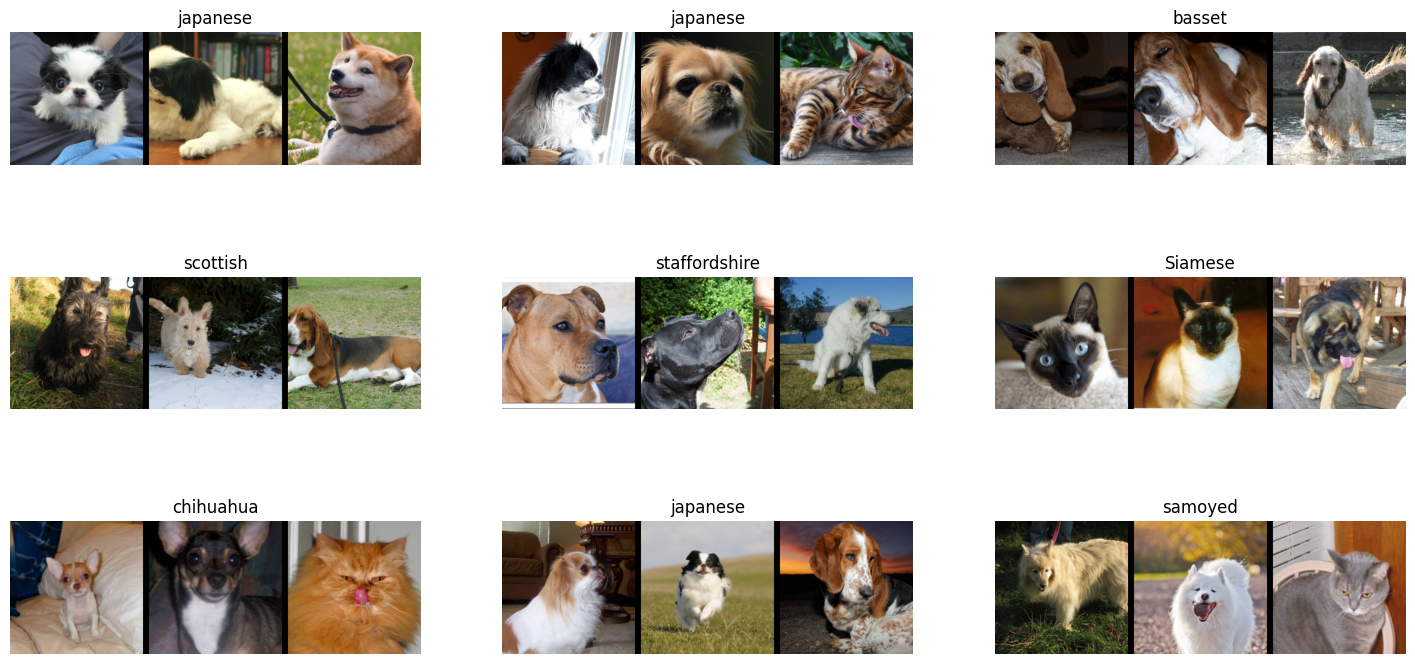

In [6]:
dls.show_batch()

In [7]:
backbone=efficientnet_v2_s(weights="DEFAULT")
#backbone=efficientnet_v2_s(weights=None)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 227MB/s]


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = create_body(backbone, cut=-2)
head = create_head(backbone.classifier[-1].in_features, 256, [1024,512], ps=0.5)
model = TripletModel(encoder, head)

In [9]:
from fastai.optimizer import Adam

class _Loss(Module):
    reduction: str
    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super(_Loss, self).__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction
class triplet_loss_func(_Loss):
    __constants__ = ['margin', 'p', 'eps', 'swap', 'reduction']
    margin: float
    p: float
    eps: float
    swap: bool

    def __init__(self, margin: float = 1.0, p: float = 2., eps: float = 1e-6, swap: bool = False, size_average=None,
                 reduce=None, reduction: str = 'mean'):
        super(triplet_loss_func, self).__init__(size_average, reduce, reduction)
        self.margin = margin
        self.p = p
        self.eps = eps
        self.swap = swap

    def forward(self, x, *args):
        anchor, positive, negatives = x[0], x[1], x[2:]
        # 计算 anchor 与 positive 的距离的平方
        pos_dist_sq = torch.sum((anchor - positive) ** 2, dim=1)
        # 初始化负样本与锚点之间的距离的列表
        neg_dists_sq = []
        # 计算负样本与锚点之间的距离的平方
        for neg in negatives:
            neg_dist_sq = torch.sum((anchor - neg) ** 2, dim=1)
            neg_dists_sq.append(neg_dist_sq)
        # 将负样本之间的距离的平方堆叠起来
        neg_dists_sq = torch.stack(neg_dists_sq, dim=1)
        # 选择每个样本的最具挑战性的负样本的索引
        hard_neg_indices = torch.argmin(neg_dists_sq, dim=1)
        # 根据索引选择最具挑战性的负样本的距离的平方
        hard_neg_dist_sq = torch.gather(neg_dists_sq, dim=1, index=hard_neg_indices.unsqueeze(1))
        # 计算 loss
        losses = F.relu(pos_dist_sq - hard_neg_dist_sq + self.margin)
        if self.reduction == 'mean':
            return torch.mean(losses)
        elif self.reduction == 'sum':
            return torch.sum(losses)
        else:
            return losses

In [10]:
def triplet_splitter(model):
    return [params(model.encoder), params(model.head)]

In [11]:
def accuracy(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    true_negatives = torch.sum((preds == 0) & (targets == 0)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0.0

    return accuracy

def precison(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0

    return precision

def recall(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return recall

def f1_score(ops, targets):
    op1, op2, op3 = ops[0], ops[1], ops[2]
    pos_dists = F.pairwise_distance(op1, op2)
    neg_dists = F.pairwise_distance(op1, op3)
    dists = torch.cat([pos_dists, neg_dists])
    targets = [1] * len(pos_dists) + [0] * len(neg_dists)
    targets = torch.tensor(targets).to(device)
    optimal_threshold.find(dists, targets)
    preds = (dists < optimal_threshold.best_threshold)

    true_positives = torch.sum((preds == 1) & (targets == 1)).item()
    false_positives = torch.sum((preds == 1) & (targets == 0)).item()
    false_negatives = torch.sum((preds == 0) & (targets == 1)).item()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

class OptimalThreshold:
    def __init__(self, start=0.1, end=5.0, step=0.01):
        self.start = start
        self.end = end
        self.step = step
        self.best_threshold = None

    def find(self, preds, targets):
        best_accuracy = 0.0
        for threshold in np.arange(self.start, self.end, self.step):
            preds_thresholded = (preds < threshold).float()
            accuracy = (preds_thresholded == targets).float().mean()
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                self.best_threshold = threshold
                
class PrintBestThreshold(Callback):
    def after_epoch(self):
        print(f"Epoch {self.learn.epoch} LR:{self.opt.hypers[0]['lr']:.10f} Best threshold: {optimal_threshold.best_threshold:.2f}")

optimal_threshold = OptimalThreshold()

In [12]:
learn = Learner(
    dls, 
    model, 
    splitter=triplet_splitter, 
    loss_func=triplet_loss_func(), 
    opt_func=Adam,
    metrics=[accuracy,precison,recall,f1_score],
    cbs=[PrintBestThreshold(),ShowGraphCallback, SaveModelCallback]
)

SuggestedLRs(valley=0.0006918309954926372)

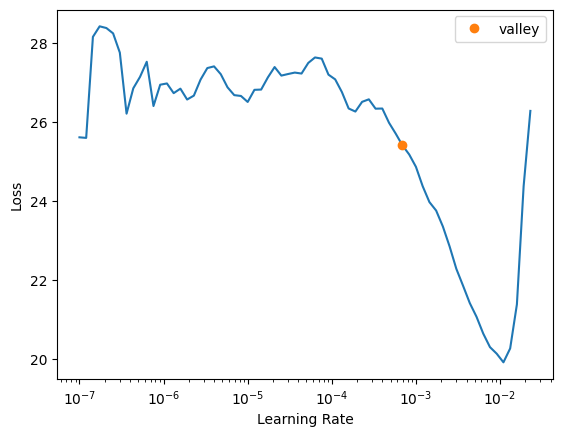

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precison,recall,f1_score,time
0,7.510867,98560.132812,0.610359,0.997292,0.221395,0.358175,02:31
1,2.074798,0.273888,0.722410,0.993761,0.447529,0.610626,02:30
2,1.883093,0.371969,0.759309,0.990650,0.523358,0.680492,02:30
3,4.326639,3.055503,0.690589,0.985751,0.386594,0.549876,02:30
4,5.049376,2.205555,0.723764,0.982310,0.456330,0.619459,02:30
5,6.432728,4.067310,0.731550,0.934980,0.498984,0.644905,02:30
6,4.353710,1.762259,0.792485,0.955318,0.615437,0.744033,02:31
7,4.106248,1.277913,0.815504,0.951070,0.666215,0.780989,02:30
8,3.072703,1.181866,0.802302,0.964823,0.627624,0.755511,02:30
9,2.745011,1.238988,0.808395,0.959815,0.643196,0.766622,02:30


Epoch 0 LR:0.0000810549 Best threshold: 3.62
Better model found at epoch 0 with valid_loss value: 98560.1328125.


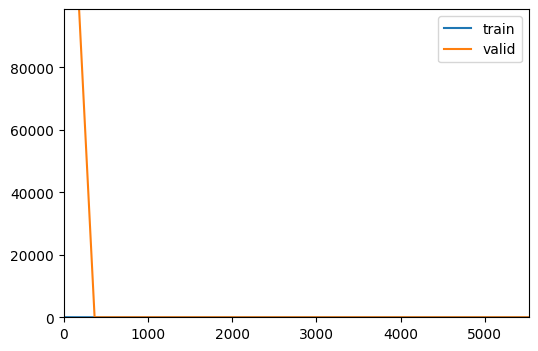

Epoch 1 LR:0.0001980061 Best threshold: 3.18
Better model found at epoch 1 with valid_loss value: 0.27388837933540344.
Epoch 2 LR:0.0003706330 Best threshold: 4.39
Epoch 3 LR:0.0005690868 Best threshold: 2.99
Epoch 4 LR:0.0007590530 Best threshold: 4.03
Epoch 5 LR:0.0009076848 Best threshold: 3.47
Epoch 6 LR:0.0009892824 Best threshold: 2.60
Epoch 7 LR:0.0009988084 Best threshold: 3.62
Epoch 8 LR:0.0009891527 Best threshold: 4.18
Epoch 9 LR:0.0009699762 Best threshold: 4.91
Epoch 10 LR:0.0009416524 Best threshold: 3.40
Epoch 11 LR:0.0009047323 Best threshold: 3.41
Epoch 12 LR:0.0008599348 Best threshold: 2.90
Epoch 13 LR:0.0008081316 Best threshold: 2.91
Epoch 14 LR:0.0007503310 Best threshold: 4.15
Epoch 15 LR:0.0006876582 Best threshold: 4.20
Epoch 16 LR:0.0006213328 Best threshold: 2.72
Better model found at epoch 16 with valid_loss value: 0.24758653342723846.
Epoch 17 LR:0.0005526461 Best threshold: 4.22
Epoch 18 LR:0.0004829346 Best threshold: 3.78
Epoch 19 LR:0.0004135555 Best th

In [14]:
learn.fit_one_cycle(30)

In [15]:
def triplet_top_losses(learn, preds=None, max_n=6, n_cols=3):
    if preds == None:
        preds = learn.get_preds(with_loss=True, with_input=True)
    ctxs = get_grid(max_n, nrows=None, ncols=n_cols, figsize=(n_cols*6, max_n//n_cols * 3), title='Triplet Loss')
    dl = learn.dls.valid.enumerate()
    topk = preds[-1].topk(max_n)
    start = time.time()
    for i, ctx in enumerate(ctxs):
        idx = topk[-1][i].item()
        loss = topk[0][i].item()
        dl[idx][1].show(loss=loss, ctx=ctx)

Epoch 0 LR:0.0000000101 Best threshold: 2.58


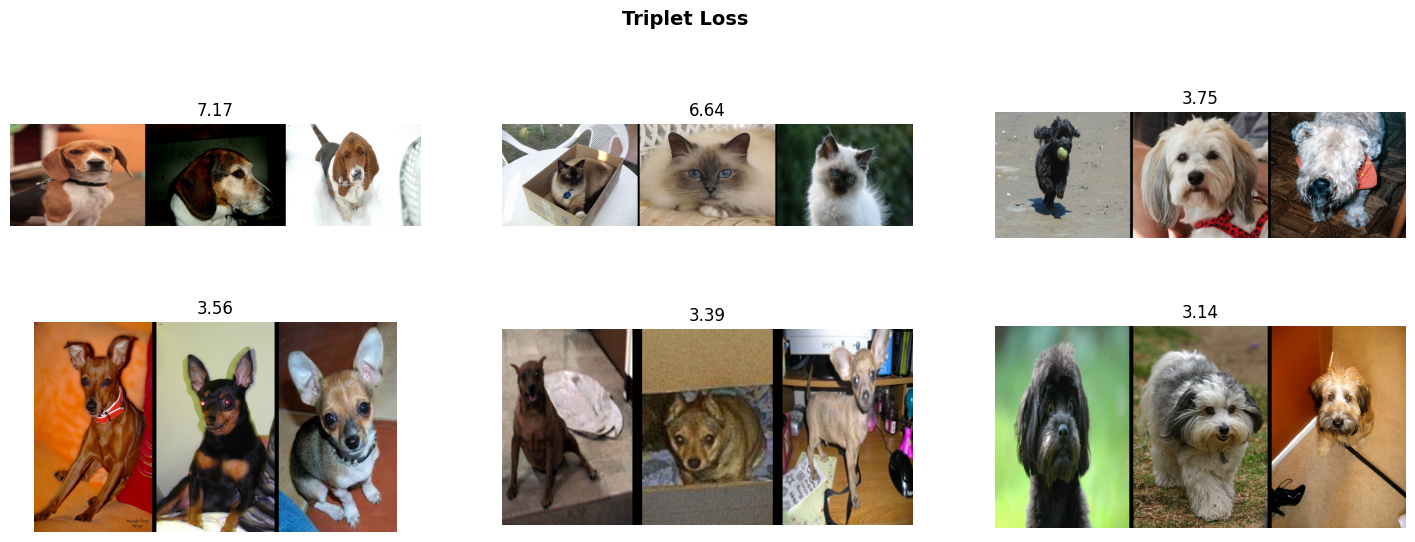

In [16]:
triplet_top_losses(learn)

In [17]:
hooks = Hooks(model.head, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0], i[1], i[2])
    ftrs = torch.cat((ftrs, nn.Flatten()(hooks.stored[-1])))

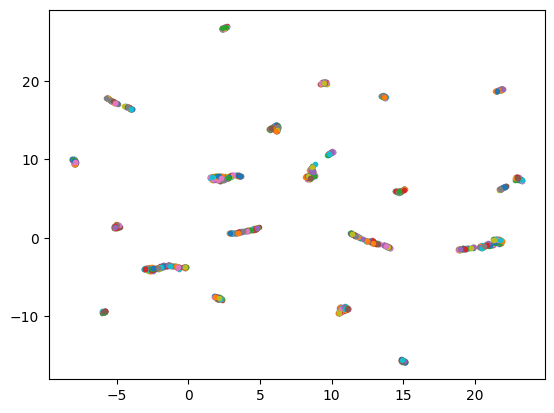

In [18]:
from umap import UMAP
umap = UMAP(n_components=2, n_neighbors=30)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

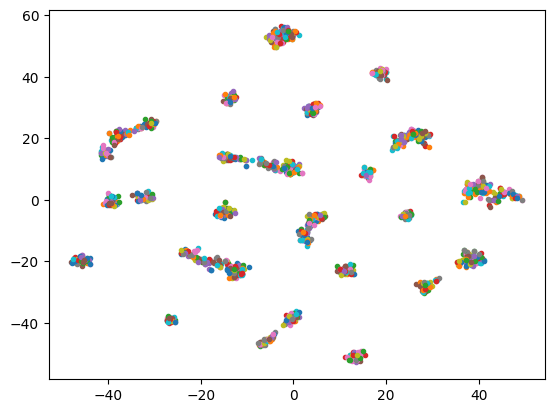

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

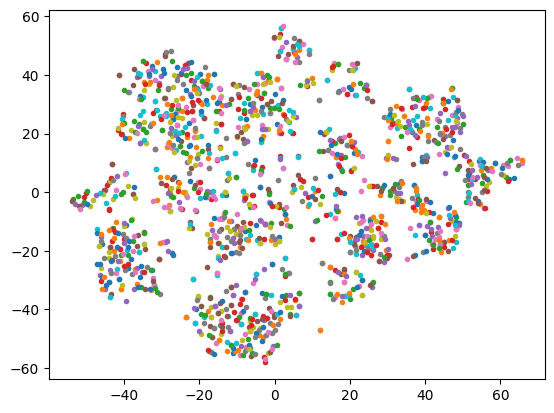

In [20]:
hooks = Hooks(model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0], i[1], i[2])
    ftrs = torch.cat((ftrs, nn.Flatten()(hooks.stored[-1])))
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')